/data/keeling/a/arkam2/anaconda27/envs/basemap/lib/python2.7/site-packages/ipykernel_launcher.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


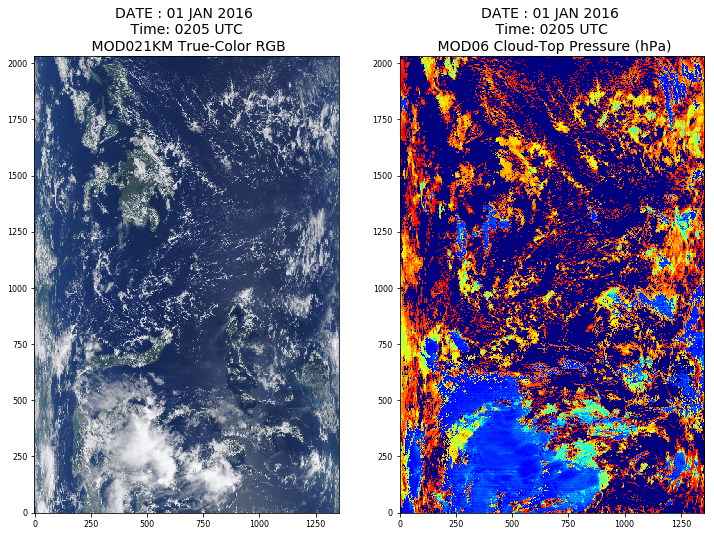

In [2]:
import glob
import matplotlib
import numpy as np
from pyhdf.SD import SD,SDC
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from skimage.util import img_as_ubyte as bytescale

MOD06_files = sorted(glob.glob('/data/keeling/a/arkam2/c/DATA_MODIS/MOD06/2016/001/*.hdf'))
MOD03_files = sorted(glob.glob('/data/keeling/a/arkam2/c/DATA_MODIS/MOD03/2016/001/*.hdf'))
MOD021_files = sorted(glob.glob('/data/keeling/a/arkam2/satellite/TerraDataArchive/MOD021KM/2016/001/*.hdf'))
times = ['0205','0455','0635','1120','1445','1620','1810','2305']
MOD06 = []; MOD03 = []; MOD021 = []
for i in range(len(times)):
    MOD06 = np.append(MOD06, [s for s in MOD06_files if times[0] in s][0])
    MOD03 = np.append(MOD03, [s for s in MOD03_files if times[0] in s][0])
    MOD021 = np.append(MOD021, [s for s in MOD021_files if times[0] in s][0])

FILE_NAME = MOD06[0]
GEO_FILE_NAME = MOD03[0]
L1_FILE_NAME = MOD021[0]
DATAFIELD_NAME = 'cloud_top_pressure_1km'
hdf = SD(FILE_NAME, SDC.READ)
hdf_geo = SD(GEO_FILE_NAME, SDC.READ)
hdf_rad = SD(L1_FILE_NAME, SDC.READ)

def process_mod021(file):
    data_id = file.select('EV_250_Aggr1km_RefSB')
    data_attributes = data_id.attributes()

    for key, value in data_attributes.iteritems():

        #print key, value
        if key == 'reflectance_scales':
            reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)		
        if key == 'reflectance_offsets':
            reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)	

    data_250_Aggr1km_RefSB = data_id.get()

    #getting to the data for 500km resolution

    data_id = file.select('EV_500_Aggr1km_RefSB')

    data_attributes = data_id.attributes()

    for key, value in data_attributes.iteritems():
        if key == 'reflectance_scales':
            reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)	
        if key == 'reflectance_offsets':
            reflectance_offsets_500_Aggr1km_RefSB = np.asarray(value)	

    data_500_Aggr1km_RefSB = data_id.get()

    #getting to the RGB color pixels

    data_shape = data_250_Aggr1km_RefSB.shape

    along_track = data_shape[1]
    cross_track = data_shape[2]

    z = np.zeros((along_track, cross_track,3))

    for i in np.arange(along_track):
        for j in np.arange(cross_track): 
            z[i,j,0] = ( data_250_Aggr1km_RefSB[0,i,j] - \
            reflectance_offsets_250_Aggr1km_RefSB[0] ) * \
            reflectance_scales_250_Aggr1km_RefSB[0] 

    for i in np.arange(along_track):
        for j in np.arange(cross_track): 
            z[i,j,1] = ( data_500_Aggr1km_RefSB[1,i,j] - \
            reflectance_offsets_500_Aggr1km_RefSB[1] ) * \
            reflectance_scales_500_Aggr1km_RefSB[1]  

    for i in np.arange(along_track):
        for j in np.arange(cross_track): 
            z[i,j,2] = ( data_500_Aggr1km_RefSB[0,i,j] - \
            reflectance_offsets_500_Aggr1km_RefSB[0] ) * \
            reflectance_scales_500_Aggr1km_RefSB[0] 

    z[ z > 1 ] = 1.0
    z[ z < 0 ] = 0.0

    #----------------------------------------------------------------------------------------#
    # Color enhancement

    x = np.array([0,  30,  60, 120, 190, 255], dtype=np.uint8)
    y = np.array([0, 110, 160, 210, 240, 255], dtype=np.uint8)

    def scale_image(image, x, y):
        scaled = np.zeros((along_track, cross_track), dtype=np.uint8)
        for i in range(len(x)-1):
            x1 = x[i]
            x2 = x[i+1]
            y1 = y[i]
            y2 = y[i+1]
            m = (y2 - y1) / float(x2 - x1)
            b = y2 - (m *x2)
            mask = ((image >= x1) & (image < x2))
            scaled = scaled + mask * np.asarray(m * image + b, dtype=np.uint8)
        mask = image >= x2
        scaled = scaled + (mask * 255)
        return scaled

    z_color_enh = np.zeros((along_track, cross_track,3), dtype=np.uint8)
    z_color_enh[:,:,0] = scale_image(bytescale(z[:,:,0]), x, y)
    z_color_enh[:,:,1] = scale_image(bytescale(z[:,:,1]), x, y)
    z_color_enh[:,:,2] = scale_image(bytescale(z[:,:,2]), x, y)

    return z_color_enh


def process_mod06(hdf):
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.double)
    attrs = data2D.attributes(full=1)
    fva=attrs["_FillValue"]
    data[data == fva] = 0 
    data = data * 0.1 
    data = np.ma.masked_array(data, np.isnan(data))
    
    return data

data = process_mod06(hdf)
z_color_enh = process_mod021(hdf_rad)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(122)

img = plt.imshow(np.flipud(data), interpolation='none', origin='lower', cmap='jet')

ticks_x_pos = [0,250,500,750,1000,1250]
ticks_x_label = ['0','250','500', '750', '1000','1250']

ticks_y_pos = [0,250,500,750,1000,1250,1500,1750,2000]
ticks_y_label = ['0','250','500', '750', '1000','1250','1500','1750','2000']

plt.xticks(ticks_x_pos, ticks_x_label, rotation=0, fontsize=8 )
plt.yticks(ticks_y_pos, ticks_y_label, rotation=0, fontsize=8 )

plt.clim(0,1100.)
plt.title('DATE : 01 JAN 2016 \n Time: 0205 UTC \n MOD06 Cloud-Top Pressure (hPa)', fontsize=14)

ax = fig.add_subplot(121)

img = plt.imshow(np.flipud(z_color_enh), interpolation='none', origin='lower')

ticks_x_pos = [0,250,500,750,1000,1250]
ticks_x_label = ['0','250','500', '750', '1000','1250']

ticks_y_pos = [0,250,500,750,1000,1250,1500,1750,2000]
ticks_y_label = ['0','250','500', '750', '1000','1250','1500','1750','2000']

plt.xticks(ticks_x_pos, ticks_x_label, rotation=0, fontsize=8 )
plt.yticks(ticks_y_pos, ticks_y_label, rotation=0, fontsize=8 )

plt.title('DATE : 01 JAN 2016 \n Time: 0205 UTC \n MOD021KM True-Color RGB', fontsize=14)

plt.show()

In [197]:
import os
import time
import numpy as np
import pandas as pd
import xarray as xr
from PIL import Image
import fm_modrad_emis
import modis_transmission
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#------------------------------------------MODIS Functions-------------------------------------

h = 6.626e-34
c = 299792458
kB = 1.38e-23
def planck(wav, T):
    #Function to calculate Planck radiation for emissivity=1, given wavelength and Temp
    a = 2.0*h*c**2
    b = h*c/(wav*kB*T)
    intensity = a/((wav**5)*(np.exp(b)-1.0))
    return intensity

P_levels = [0.0050,    0.0161,    0.0384,    0.0769,    0.1370,\
   0.2244,    0.3454,    0.5064,    0.7140,    0.9753,    1.2972,\
   1.6872,    2.1526,    2.7009,    3.3398,    4.0770,    4.9204,\
   5.8776,    6.9567,    8.1655,    9.5119,   11.0038,   12.6492,\
  14.4559,   16.4318,   18.5847,   20.9224,   23.4526,   26.1829,\
  29.1210,   32.2744,   35.6505,   39.2566,   43.1001,   47.1882,\
  51.5278,   56.1260,   60.9895,   66.1253,   71.5398,   77.2396,\
  83.2310,   89.5204,   96.1138,  103.0172,  110.2366,  117.7775,\
 125.6456,  133.8462,  142.3848,  151.2664,  160.4959,  170.0784,\
 180.0183,  190.3203,  200.9887,  212.0277,  223.4415,  235.2338,\
 247.4085,  259.9691,  272.9191,  286.2617,  300.0000,  314.1369,\
 328.6753,  343.6176,  358.9665,  374.7241,  390.8926,  407.4738,\
 424.4698,  441.8819,  459.7118,  477.9607,  496.6298,  515.7200,\
 535.2322,  555.1669,  575.5248,  596.3062,  617.5112,  639.1398,\
 661.1920,  683.6673,  706.5654,  729.8857,  753.6275,  777.7897,\
 802.3714,  827.3713,  852.7880,  878.6201,  904.8659,  931.5236,\
 958.5911,  986.0666, 1013.9476, 1042.2319, 1070.9170, 1100.0000]

wv = [13.335*1e-6,13.935*1e-6,14.235*1e-6]
mod_band =[33,35,36]
#-------------------------------------------------------------------------------------------------

#-------------------------Local Directories and Reanalysis Files----------------------------------

main_directory = '/data/keeling/a/arkam2/c/Reanalysis/era5_files/2016/'
main_directory2 = '/data/keeling/a/arkam2/c/Reanalysis/standard/'
libradtran_dir = '/data/keeling/a/arkam2/libRadtran-2.0.2/'
geode = np.loadtxt('/data/gdi/c/arkam2/Reanalysis/standard/OUTPUT.DAT')
scales = [2.6226387e-4,1.7670827e-4,1.1833857e-4]
offsets = [2501.2976,2501.2979,2501.2979]

#these are modified versions with the first commented line removed so that read_fwf works okay.
#there is still a dead first column that is removed when gas_mixing_ratios are turned into a xarray dataset.
afglms = pd.read_fwf(os.path.join(main_directory2,'afglms.dat'))
afglmw = pd.read_fwf(os.path.join(main_directory2,'afglmw.dat'))
afglsw = pd.read_fwf(os.path.join(main_directory2,'afglsw.dat'))
afglss = pd.read_fwf(os.path.join(main_directory2,'afglss.dat'))
afglt = pd.read_fwf(os.path.join(main_directory2,'afglt.dat'))

def find_coord_index(lat,lon):
    nlat = (90. + lat + 90/180).astype(int)
    nlon = (lon+180.).astype(int)
    return nlat,nlon
def find_coord_index_reanalysis(lat,lon):
    nlat = np.where(np.abs(sst6.latitude.values-lat)<0.25)[0][0]
    nlon = np.where(np.abs(sst6.longitude.values-np.abs(lon+180.))<0.25)[0][0]
    return nlat,nlon

def trapezoidal(B, t, n):
    s = 0.
    for i in range(0, n-1):
        h = 0.5*(t[i+1]+t[i])*(B[i+1]-B[i])
        s += h
    return s

def modCTP(P_levels, diff):
    asign = np.sign(diff)
    signchange = (np.abs((np.roll(asign, 1) - asign)) != 0).astype(int)
    signchange[0] = 0
    return (P_levels[np.where(signchange==1)]), (diff[np.where(signchange==1)])

def read_reanalysis_files1():
    sst0 = xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_sst.nc'))
    skin0 = xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_skin.nc'))
    sfp0 = xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_surfP.nc'))
    temp0= xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_temp.nc'))
    shum0= xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_shum.nc'))
    geo0= xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_geo.nc'))
    data_2mT0 = xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_2mT.nc')) 
    data_2mD0 = xr.open_dataset(os.path.join(main_directory,'era5_0UTC_2016_2mD.nc'))
    sst12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_sst.nc'))
    skin12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_skin.nc'))
    sfp12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_surfP.nc'))
    temp12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_temp.nc'))
    shum12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_shum.nc'))
    geo12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_geo.nc'))
    data_2mT12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_2mT.nc')) 
    data_2mD12 = xr.open_dataset(os.path.join(main_directory,'era5_12UTC_2016_2mD.nc'))
    emiss = Dataset(os.path.join(main_directory2,'surface_emissivity_Fu-Liou_0.5x0.5_53deg.nc'),'r')
    
    return sst0, skin0, sfp0, temp0, shum0, geo0, data_2mT0, data_2mD0, sst12, skin12, sfp12, temp12, shum12, geo12,\
            data_2mT12, data_2mD12, emiss

def read_reanalysis_files2():
    sst6 = xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_sst.nc'))
    skin6 = xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_skin.nc'))
    sfp6 = xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_surfP.nc'))
    temp6= xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_temp.nc'))
    shum6= xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_shum.nc'))
    geo6= xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_geo.nc'))
    data_2mT6 = xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_2mT.nc')) 
    data_2mD6 = xr.open_dataset(os.path.join(main_directory,'era5_6UTC_2016_2mD.nc'))
    sst18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_sst.nc'))
    skin18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_skin.nc'))
    sfp18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_surfP.nc'))
    temp18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_temp.nc'))
    shum18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_shum.nc'))
    geo18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_geo.nc'))
    data_2mT18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_2mT.nc')) 
    data_2mD18 = xr.open_dataset(os.path.join(main_directory,'era5_18UTC_2016_2mD.nc'))
    emiss = Dataset(os.path.join(main_directory2,'surface_emissivity_Fu-Liou_0.5x0.5_53deg.nc'),'r')
    
    return sst6, skin6, sfp6, temp6, shum6, geo6, data_2mT6, data_2mD6, sst18, skin18, sfp18, temp18, shum18, geo18,\
            data_2mT18, data_2mD18, emiss

def co2_slicing_vars(transm,B,wt,P_levels,Ps,e,skin,band):
    I=[]; Ics=[]
    strans = transm[np.max(np.where(P_levels<Ps))]
    sB = planck(wv[band],skin)*1e-6; lsfc = np.max(np.where(P_levels<Ps))
    for ilevel in range(len(P_levels[np.where(P_levels<Ps)])):
        Pt = P_levels[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<Ps))]; n = len(Pt)
        if (len(Pt)>=2):
            I = np.append(I,B[ilevel]*transm[ilevel] + trapezoidal(B, transm, n))
        else:
            I = np.append(I, np.nan)
    I = np.append(I, np.ones(len(P_levels)-len(I))*np.nan)
    Pt = P_levels[np.where(P_levels<Ps)]; n=len(Pt)
    Ics = e*sB*strans + trapezoidal(B, transm, n)
    
    return I, Ics

def dt_dlnP(P,t):
    #Function to calculate normalized wighting functions for a MODIS band, given P and 
    #transmittance profiles
    dtdlnP = np.zeros(len(P))
    for i in range(len(P)-2):
        dtdlnP[i] = -(t[i]-t[i+1])/(np.log(P[i])-np.log(P[i+1]))
#     dtdlnP[len(P)-1] = dtdlnP[i] 
    wt_fn = [(dtdlnP[i]-np.min(dtdlnP))/(np.max(dtdlnP)-np.min(dtdlnP))
             for i in range(len(dtdlnP))]
    return wt_fn

def delI(transm,B,wt,P_levels,Ps,misrp):
    ilevel = np.max(np.where(P_levels<misrp))
    Pt = np.array(P_levels)[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<Ps))]; n=len(Pt)
    Il = B[ilevel]*transm[ilevel] + trapezoidal(B, transm, n)
    if np.isnan(Il)==True:
        delI = 0.5*(transm[ilevel]+transm[ilevel+1])*(B[ilevel]-B[ilevel+1])
    elif np.isnan(Il)==False:
        delI = Il
    if (Ps<misrp):
        delI = 0.
    return delI

sst0, skin0, sfp0, temp0, shum0, geo0, data_2mT0, data_2mD0,sst12, skin12, sfp12,\
temp12, shum12, geo12, data_2mT12, data_2mD12, emiss = read_reanalysis_files1()
sst6, skin6, sfp6, temp6, shum6, geo6, data_2mT6, data_2mD6,sst18, skin18, sfp18,\
temp18, shum18, geo18, data_2mT18, data_2mD18, emiss = read_reanalysis_files2()
#-----------------------------------------------------------------------------------------------------------------

#------------------------------------RUN LIBRADTRAN and GAS TRANSMISSION------------------------------------------
def calculate_radiances(i,j, day, band, mu, sstemp, skint, sfpres, temp, shum, geo, data_2mT, data_2mD, emiss, zouts = 'all',
                        afglms=afglms, afglmw=afglmw, afglsw=afglsw, afglss=afglss, afglt=afglt):

    month = sstemp['time.month'][day].data
    column_lat = sstemp.latitude[i]
    column_lon = sstemp.longitude[j]
    e = emiss['band_emissivity'][month-1,:,:,4] #Fu-Liou band between 670-800 cm-1
    e = np.array(Image.fromarray(e).resize((np.shape(sstemp.sst[0,:,:])[1],np.shape(sstemp.sst[0,:,:])[0])))
    albedo = 1-e[i,j]

    #random logic to choose the best reference atmosphere for trace gases. . .
    #probably not the best choice of months blah blah.
    if np.abs(column_lat) < 30.0:
        profile = afglt
    elif ((column_lat >= 30.0) & (month in (4,5,6,7,8,9))) | ((column_lat <= -30.0) & (month in (1,2,3,10,11,12))):
        if np.abs(column_lat) >= 60.0:
            profile = afglss
        else:
            profile = afglms
    else:
        if np.abs(column_lat) >= 60.0:
            profile = afglsw
        else:
            profile = afglmw
#     print(profile)
    
    o3_mixing_ratios = np.stack(profile['o3(cm-3)'].values/profile['air(cm-3)'].values*1e6,axis=-1)
    o3_mixing_ratios = xr.Dataset(
        data_vars = {
            'ozone_mixing_ratio' : (['pressure'], o3_mixing_ratios)
        },
        coords = {
            'pressure': profile['p(mb)'].values
        }
    )
    #make the vertical coordiatnes of pressure, temperature, height and specific humidity.

    T = temp.t[day,:,i,j].data
    skin = skint.skt[day,i,j].data
    q = shum.q[day,:,i,j].data
    pressures = temp.level.data.astype(np.float32)
    if len(np.where(q<0.)) > 0:
        pressures_ = pressures[np.where(q>0.)]
        q_ = q[np.where(q>0.)]
        fq = interp1d(np.log(pressures_),q_,fill_value='extrapolate')
        q = fq(np.log(pressures))
    sfp = sfpres.sp[day,i,j].data/100.0
    z_levels = geo.z[day,:,i,j].data/9.8e3

    t2 = data_2mT.t2m[day,i,j]
    d2 = data_2mD.d2m[day,i,j]
    spec_hum_2m = 622.0 *6.113e2 * np.exp(5423.0 * (d2 - 273.15)/(d2 * 273.15))/(1000.0 * sfp)

    #remove all levels that are below surface pressure.
    bad_levels = np.where(pressures > sfp)[0]
    if len(bad_levels) > 0:
        min_index = bad_levels.min()
        z_levels = z_levels[:min_index]
        pressures = pressures[:min_index]
        T = T[:min_index]
        q = q[:min_index]
        
    #hack to avoid duplicated z_levels in atmosphere file due to rounding.
    T1 = T[-1]
    if np.round(z_levels[-1],3) == np.array([0.0]):
        z_levels = z_levels[:-1]
        pressures = pressures[:-1]
        T = T[:-1]
        q = q[:-1]
        
    #add surface level data.
    T = T[np.where(z_levels>0.)]
    q = q[np.where(z_levels>0.)]
    pressures = pressures[np.where(z_levels>0.)]
    z_levels = z_levels[np.where(z_levels>0.)]
    z_levels = np.append(z_levels, np.array([0.0]))
    pressures = np.append(pressures, sfp)
    if not np.isnan(sstemp.sst[day,i,j].data):
        T = np.append(T, sstemp.sst[day,i,j].data)
    else:
        T = np.append(T, t2.data)
    if np.isnan(T[len(T)-1]) or np.abs(T[len(T)-1]-T1)>5.:
        T[len(T)-1] = T1+(z_levels[len(T)-2]*6.5)
    q = np.append(q, spec_hum_2m.data)

    #calculate density
    #ratio = (pressures * 100.0 / (T * 1.38064852e-23))*1e-6
    h2o = q*1e3

    high_col = profile.iloc[np.logical_and(profile['p(mb)'].values<1., profile['p(mb)'].values>0.0005)]
    pressures = np.append(high_col['p(mb)'], pressures)
    h2o = np.append(high_col['h2o(cm-3)'].values/high_col['air(cm-3)'].values*18.016/28.966*1e3, h2o)
    o3 = o3_mixing_ratios.interp(pressure=P_levels).bfill(dim='pressure').ffill(dim='pressure')
    T = np.append(high_col['T(K)'], T); o3 = o3.ozone_mixing_ratio.values
    fT = interp1d(np.log(pressures),T,fill_value='extrapolate')
    fwv = interp1d(np.log(pressures),h2o,fill_value='extrapolate')
    T = fT(np.log(P_levels)); h2o = fwv(np.log(P_levels))
    T_ = T[np.where(np.logical_and(np.array(P_levels)>20.,np.array(P_levels)<600.))]
    P_ = np.array(P_levels)[np.where(np.logical_and(np.array(P_levels)>20.,np.array(P_levels)<600.))]
#     tropo = P_[np.where(T_==np.min(T_))][0]
    tropo = P_[np.max(np.where(np.gradient(T_)<=0.025))]
    taut = modis_transmission.tran_modisd101(year=2015,jday=2,temp=T,wvmr=h2o,ozmr=o3,
                                            theta=0.0,kban=mod_band[band],jdet=0)
    taut[np.where(P_levels>=sfp)] = np.nan; BT = planck(wv[band],T)*1e-6; BT[np.where(P_levels>=sfp)] = np.nan
    return taut, BT, sfp, e[i,j], tropo, skin, T

hr = int(times[0][0:2]); doy = 0
def find_reanalysis(nlat,nlon, doy,vza, sst0, skin0, sfp0, temp0, shum0,
                     geo0, data_2mT0, data_2mD0, sst6, skin6, sfp6, temp6, shum6,
                     geo6, data_2mT6, data_2mD6, sst12, skin12, sfp12, temp12, shum12,
                     geo12, data_2mT12, data_2mD12, sst18, skin18, sfp18, temp18, shum18,
                     geo18, data_2mT18, data_2mD18, emiss):
    if (hr<3):
        geo = geo0
        transm33, BT33, sp33, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 0,
                         vza, sst0, skin0, sfp0, temp0, shum0,
                         geo0, data_2mT0, data_2mD0, emiss)  
        transm35, BT35, sp35, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 1,
                         vza, sst0, skin0, sfp0, temp0, shum0,
                         geo0, data_2mT0, data_2mD0, emiss)  
        transm36, BT36, sp36, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 2,
                         vza, sst0, skin0, sfp0, temp0, shum0,
                         geo0, data_2mT0, data_2mD0, emiss)  

    elif (hr>=3 and hr <9):
        geo = geo6
        transm33, BT33, sp33, e, tropo, skin, T = calculate_radiances(nlat,nlon, doy, 0,
                         vza, sst6, skin6, sfp6, temp6, shum6,
                         geo6, data_2mT6, data_2mD6, emiss)  
        transm35, BT35, sp35, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 1,
                         vza, sst6, skin6, sfp6, temp6, shum6,
                         geo6, data_2mT6, data_2mD6, emiss)  
        transm36, BT36, sp36, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 2,
                         vza, sst6, skin6, sfp6, temp6, shum6,
                         geo6, data_2mT6, data_2mD6, emiss)  

    elif (hr>=9 and hr <15):
        geo = geo12
        transm33, BT33, sp33, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 0,
                         vza, sst12, skin12, sfp12, temp12, shum12,
                         geo12, data_2mT12, data_2mD12, emiss)  
        transm35, BT35, sp35, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 1,
                         vza, sst12, skin12, sfp12, temp12, shum12,
                         geo12, data_2mT12, data_2mD12, emiss)  
        transm36, BT36, sp36, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 2,
                         vza, sst12, skin12, sfp12, temp12, shum12,
                         geo12, data_2mT12, data_2mD12, emiss)

    elif (hr>=15 and hr <21):
        geo = geo18
        transm33, BT33, sp33, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 0,
                         vza, sst18, skin18, sfp18, temp18, shum18,
                         geo18, data_2mT18, data_2mD18, emiss)  
        transm35, BT35, sp35, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 1,
                         vza, sst18, skin18, sfp18, temp18, shum18,
                         geo18, data_2mT18, data_2mD18, emiss)  
        transm36, BT36, sp36, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 2,
                         vza, sst18, skin18, sfp18, temp18, shum18,
                         geo18, data_2mT18, data_2mD18, emiss)

    elif (hr>=21):
        geo = geo0
        transm33, BT33, sp33, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 0,
                         vza, sst0, skin0, sfp0, temp0, shum0,
                         geo0, data_2mT0, data_2mD0, emiss)  
        transm35, BT35, sp35, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 1,
                         vza, sst0, skin0, sfp0, temp0, shum0,
                         geo0, data_2mT0, data_2mD0, emiss)   
        transm36, BT36, sp36, e, tropo, skin,T = calculate_radiances(nlat,nlon, doy, 2,
                         vza, sst0, skin0, sfp0, temp0, shum0,
                         geo0, data_2mT0, data_2mD0, emiss)
        
    return transm33, BT33, sp33, transm35, BT35, sp35, transm36, BT36, sp36, e, tropo, skin, T, geo

def choose_ctp_solution(CTP1, CTP2, tropo, ctp):
    best=np.nan
    if np.isnan([CTP2])==False:
        if CTP2<450. and CTP2>=tropo:
            best=CTP2
        elif CTP2<450. and CTP2<tropo:
            best=tropo
    elif np.isnan([CTP2])==True and np.isnan([CTP1])==False:
        if CTP1<650. and CTP1>=tropo:
            best=CTP1
        elif CTP1<650. and CTP1<tropo:
            best=tropo
    elif np.isnan([CTP1])==False and np.isnan([CTP2])==False:
        if CTP1<650.:
            best=CTP1
        if CTP2<450.:
            best=CTP2
        else:
            best=CTP1
    elif np.isnan([CTP1])==True and np.isnan([CTP2])==True:
            best=ctp
            
    return best

mod_lat=[]; mod_lon=[]; data_33=[]; data_35=[]; data_36=[]
mod_ctp =[]; mod_ct_method=[]; mod_vza=[]
lati = hdf_geo.select('Latitude'); latit = lati[:,:]
long = hdf_geo.select('Longitude'); longit = long[:,:]
mod_lat=np.append(mod_lat,latit.ravel())
mod_lon=np.append(mod_lon,longit.ravel())
data_selected_id = hdf_rad.select('EV_1KM_Emissive')
data_33 = np.append(data_33, np.ravel((data_selected_id[12,:,:] - offsets[0]) * scales[0]))
data_35 = np.append(data_35, np.ravel((data_selected_id[14,:,:] - offsets[1]) * scales[1]))
data_36 = np.append(data_36, np.ravel((data_selected_id[15,:,:] - offsets[2]) * scales[2]))
modis_points = np.dstack([mod_lat,mod_lon])[0]
ctp = hdf.select('cloud_top_pressure_1km').get()
mod_ctp = np.append(mod_ctp, ctp.ravel()*0.1); mod_ctp2=mod_ctp
modis_ct_method = hdf.select('cloud_top_method_1km').get()
mod_ct_method = np.append(mod_ct_method, modis_ct_method.ravel())
vza = hdf_geo.select('SensorZenith');modis_vza = vza[:,:]
mod_vza = np.append(mod_vza, modis_vza.ravel()); mod_vza = mod_vza*0.01
count=0; start=time.time()
for i in range(40000):
    if mod_ct_method[i]<5:
        count=count+1;print(i,count)
        nlat,nlon = find_coord_index_reanalysis(mod_lat[i],mod_lon[i])
        rad1 = data_33[i]; rad2 = data_35[i]; rad3 = data_36[i]
        transm33, BT33, sp33, transm35, BT35, sp35, transm36, BT36, sp36, e, tropo, skin, \
        T, geo = find_reanalysis(nlat,nlon, doy, mod_vza[i], sst0, skin0, sfp0, temp0, shum0,
                     geo0, data_2mT0, data_2mD0, sst6, skin6, sfp6, temp6, shum6,
                     geo6, data_2mT6, data_2mD6, sst12, skin12, sfp12, temp12, shum12,
                     geo12, data_2mT12, data_2mD12, sst18, skin18, sfp18, temp18, shum18,
                     geo18, data_2mT18, data_2mD18, emiss)
    #     delz = float(geode[np.where(np.logical_and(int(geo.latitude.data[nlat])==geode[:,0],
    #                          int(geo.longitude.data[nlon])==geode[:,1])),2])/1e3
        P = geo.level.data; geo = geo.z[doy,:,nlat,nlon]; geo = geo/9.8e3
    #     fz = interp1d(geo, np.log(P), fill_value='extrapolate')   
        wt33 = dt_dlnP(np.array(P_levels)[np.where(P_levels<sp33)],transm33)
        wt33 = np.append(wt33,np.ones(len(P_levels)-len(np.array(P_levels)[np.where(P_levels<sp33)]))*np.nan)
        wt35 = dt_dlnP(np.array(P_levels)[np.where(P_levels<sp33)],transm35)
        wt35 = np.append(wt35,np.ones(len(P_levels)-len(np.array(P_levels)[np.where(P_levels<sp33)]))*np.nan)
        wt36 = dt_dlnP(np.array(P_levels)[np.where(P_levels<sp33)],transm36)
        wt36 = np.append(wt36,np.ones(len(P_levels)-len(np.array(P_levels)[np.where(P_levels<sp33)]))*np.nan)

        I1, rclr1 = co2_slicing_vars(transm33,BT33,wt33,np.array(P_levels),sp33,e,skin,0)
        I2, rclr2 = co2_slicing_vars(transm35,BT35,wt35,np.array(P_levels),sp33,e,skin,1)
        I3, rclr3 = co2_slicing_vars(transm36,BT36,wt36,np.array(P_levels),sp33,e,skin,2)

        obs_ratio1 = (rclr1-rad1)/(rclr2-rad2); anc_ratio1 = (I1-rclr1)/(I2-rclr2)
        obs_ratio2 = (rclr2-rad2)/(rclr3-rad3); anc_ratio2 = (I2-rclr2)/(I3-rclr3)
        diff1 = obs_ratio1-anc_ratio1; diff2 = obs_ratio2-anc_ratio2 
        CTP1, d1 = modCTP(np.array(P_levels),diff1); d1 = d1[np.where(np.logical_and(CTP1>=50.,CTP1<=680.))]
        if (len(d1)>0):
            CTP1 = CTP1[np.where(np.logical_and(CTP1>=50.,CTP1<=680.))]; CTP1 = CTP1[np.where(np.abs(d1)==np.nanmin(np.abs(d1)))][0]
        else:
            CTP1=np.nan
        CTP2, d2 = modCTP(np.array(P_levels),diff2); d2 = d2[np.where(np.logical_and(CTP2>=50.,CTP2<=680.))]
        if (len(d2)>0.):
            CTP2 = CTP2[np.where(np.logical_and(CTP2>=50.,CTP2<=680.))]; CTP2 = CTP2[np.where(np.abs(d2)==np.nanmin(np.abs(d2)))][0]
        else:
            CTP2 = np.nan
        re_ctp = choose_ctp_solution(CTP1, CTP2, tropo, mod_ctp[i])
        mod_ctp2[i] = re_ctp
print(time.time()-start)

(252, 1)


/data/keeling/a/arkam2/anaconda27/envs/basemap/lib/python2.7/site-packages/ipykernel_launcher.py:162: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


(253, 2)
(254, 3)
(255, 4)
(1245, 5)
(1297, 6)
(1609, 7)
(2599, 8)
(2651, 9)
(2652, 10)
(3953, 11)
(3954, 12)
(4005, 13)
(4026, 14)
(4314, 15)
(4315, 16)
(5308, 17)
(5359, 18)
(5360, 19)
(5407, 20)
(5408, 21)
(5409, 22)
(6713, 23)
(6763, 24)
(6764, 25)
(8016, 26)
(8066, 27)
(8088, 28)
(8090, 29)
(8117, 30)
(9256, 31)
(9257, 32)
(9373, 33)
(9444, 34)
(9471, 35)
(10611, 36)
(10725, 37)
(10726, 38)
(10728, 39)
(10797, 40)
(10826, 41)
(10827, 42)
(11086, 43)
(11087, 44)
(12080, 45)
(12081, 46)
(12082, 47)
(12083, 48)
(12142, 49)
(12182, 50)
(12438, 51)
(12444, 52)
(13436, 53)
(13437, 54)
(13493, 55)
(13495, 56)
(13496, 57)
(13536, 58)
(13794, 59)
(13795, 60)
(13798, 61)
(14787, 62)
(14788, 63)
(14859, 64)
(14860, 65)
(14888, 66)
(14889, 67)
(16142, 68)
(16143, 69)
(16144, 70)
(16213, 71)
(16242, 72)
(16243, 73)
(17385, 74)
(17498, 75)
(17499, 76)
(17567, 77)
(17596, 78)
(17597, 79)
(17598, 80)
(18738, 81)
(18739, 82)
(18740, 83)
(18851, 84)
(18852, 85)
(18854, 86)
(18908, 87)
(18910, 88)
(

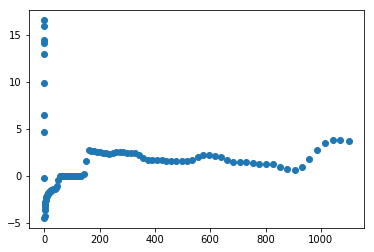

In [162]:
plt.scatter(P_levels, np.gradient(T))#;plt.gca().twinx();plt.plot(P_levels, T,'r');plt.show()

In [194]:
np.size(mod_lat),np.size(np.where(mod_ct_method<5))

(2748620, 426980)

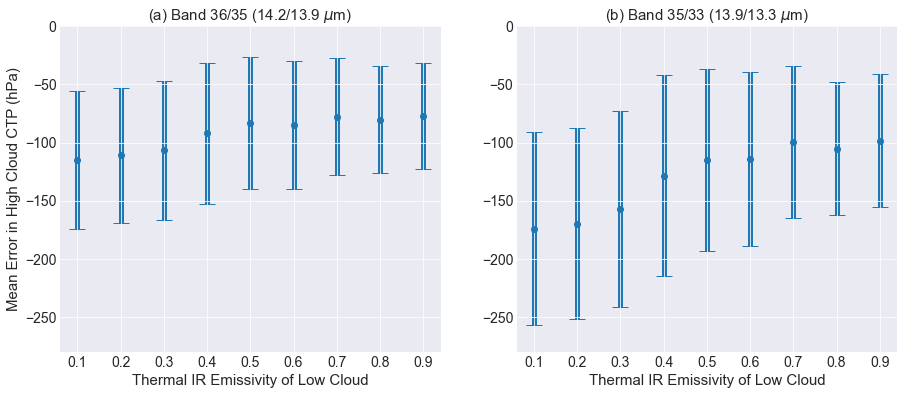

In [1]:
import glob
import numpy as np
import xarray as xr

mean_err = np.zeros(9); std_err = np.zeros(9)
ermat = sorted(glob.glob('C:/Users/arkam/Box/Prelim/Manuscript2/*withOD.nc')); error = np.zeros((5,9,10,6,5,8,2,2))
for i in range(len(ermat)):
    error[i,:,:,:,:,:,:,:] = xr.open_dataset(ermat[i]).__xarray_dataarray_variable__.data
    
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
for i in range(1,10):
    mean_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,:,0])
    std_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,:,1])
fig = plt.figure(figsize=(15,6));fig.set_facecolor('w')
plt.subplot(1,2,1);plt.scatter(np.arange(1,10)/10., mean_err); plt.ylim(-280,0)
plt.errorbar(np.arange(1,10)/10., mean_err, yerr = std_err, zorder=0, fmt ='none', capsize=8, elinewidth=5)
plt.xlabel('Thermal IR Emissivity of Low Cloud', fontsize=15); 
plt.title('(a) Band 36/35 (14.2/13.9 $\mu$m)', fontsize=15)
plt.ylabel('Mean Error in High Cloud CTP (hPa)', fontsize=15);
for l in plt.gca().yaxis.get_ticklabels():
    l.set_fontsize(14)
for l in plt.gca().xaxis.get_ticklabels():
    l.set_fontsize(14)
for i in range(1,10):
    mean_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,1,0])
    std_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,1,1])
plt.subplot(1,2,2);plt.scatter(np.arange(1,10)/10., mean_err); plt.ylim(-280,0); 
plt.title('(b) Band 35/33 (13.9/13.3 $\mu$m)', fontsize=15)
plt.errorbar(np.arange(1,10)/10., mean_err, yerr = std_err, zorder=0, fmt ='none', capsize=8, elinewidth=5);
for l in plt.gca().yaxis.get_ticklabels():
    l.set_fontsize(14)
for l in plt.gca().xaxis.get_ticklabels():
    l.set_fontsize(14)
plt.xlabel('Thermal IR Emissivity of Low Cloud', fontsize=15)
# plt.suptitle('High Cloud CTP = 350 hPa, Low Cloud CTP = 800 hPa', fontsize=14)

plt.savefig('C:/Users/arkam/Box/Prelim/Manuscript2/Plots/errors_with_lowcloudOD.png', dpi=450); 
plt.show()

In [ ]:
co2 = 